<a href="https://colab.research.google.com/github/Joyboyyya/Transliteration/blob/main/Hindi2EnglishTransliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import pickle

# Instantiates the device to be used as GPU/CPU based on availability
#device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output

import random

In [ ]:
#device_gpu

In [ ]:
eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '-PAD-'

eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [ ]:
## Train data file
!wget -nc -q --show-progress https://github.com/GokulNC/NLP-Exercises/raw/master/Transliteration-Indian-Languages/Original-NEWS2012-data/Training/NEWS2012-Training-EnHi-13937.xml
## Test data file
!wget -nc -q --show-progress https://raw.githubusercontent.com/GokulNC/NLP-Exercises/master/Transliteration-Indian-Languages/Original-NEWS2012-data/Ref/NEWS2012-Ref-EnHi-1000.xml

NEWS2012-Training-E 100%[===================>]   1.65M  --.-KB/s    in 0.06s   
NEWS2012-Ref-EnHi-1 100%[===================>] 112.27K  --.-KB/s    in 0.02s   


In [ ]:

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

In [ ]:
import re
non_eng_letters_regex = re.compile('[^a-zA-Z ]')

def cleanEnglishVocabulary(line):
    line = line.replace('-', ' ').replace(',', ' ').upper()

    line = non_eng_letters_regex.sub('', line)
    return line.split()

def cleanHindiVocabulary(line):
    line = line.replace('-', ' ').replace(',', ' ')

    cleaned_line = ''
    for char in line:
        if char in hindi_alpha2index or char == ' ':
            cleaned_line += char

    return cleaned_line.split()

In [ ]:
from torch.utils.data import Dataset
import xml.etree.ElementTree as ET
from lxml import etree

class LSTM_TransliterationDataLoader(Dataset):
    def __init__(self, filename):
        self.eng_words, self.hindi_words = self.readXmlDataset(filename, cleanHindiVocabulary)
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0

    def __len__(self):
        return len(self.eng_words)

    def __getitem__(self, idx):
        return self.eng_words[idx], self.hindi_words[idx]

    def readXmlDataset(self, filename, lang_vocab_cleaner):
        transliterationCorpus = ET.parse(filename).getroot()
        lang1_words = []
        lang2_words = []

        for line in transliterationCorpus:
            wordlist1 = cleanEnglishVocabulary(line[0].text)
            wordlist2 = lang_vocab_cleaner(line[1].text)


            if len(wordlist1) != len(wordlist2):
                print('Skipping: ', line[0].text, ' - ', line[1].text)
                continue

            for word in wordlist1:
                lang1_words.append(word)
            for word in wordlist2:
                lang2_words.append(word)

        return lang1_words, lang2_words

    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))

    def get_batch_from_array(self, batch_size, array):
        end = self.shuffle_start_index + batch_size
        batch = []
        if end >= len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index : end]]

    def get_batch(self, batch_size, postprocess = True):
        eng_batch = self.get_batch_from_array(batch_size, self.eng_words)
        hindi_batch = self.get_batch_from_array(batch_size, self.hindi_words)
        self.shuffle_start_index += batch_size + 1

        # Reshuffle if 1 epoch is complete
        if self.shuffle_start_index >= len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0

        return eng_batch, hindi_batch

train_data = LSTM_TransliterationDataLoader('NEWS2012-Training-EnHi-13937.xml')
test_data = LSTM_TransliterationDataLoader('NEWS2012-Ref-EnHi-1000.xml')

In [ ]:
print("Train Set Size:\t", len(train_data))
print("Test Set Size:\t", len(test_data))

print('\nSample data from train-set:')
for i in range(10):
    eng, hindi = train_data.get_random_sample()
    print(eng + ' - ' + hindi)

Train Set Size:	 20641
Test Set Size:	 1000

Sample data from train-set:
RUIGENHOEKSEDIJK - रुगनहोएकसेडिज्क
WAR - वार
PARAVEJ - परवेज
UNUNBIUM - यूननबियम
RAILWAY - रेल्वे
ANANDI - आनंदी
RIVER - रिवर
WALTZ - वाल्ट्ज
HUM - हम
KARIAKOIL - करियाकोइल


In [ ]:
def word_representation(word, letter2index, device = 'cpu'):
    rep = torch.zeros(len(word)+1, 1, len(letter2index)).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][0][pos] = 1
    pad_pos = letter2index[pad_char]
    rep[letter_index+1][0][pad_pos] = 1
    return rep

def ground_truth_representation(word, letter2index, device = 'cpu'):
    ground_truth_representation = torch.zeros([len(word)+1, 1], dtype=torch.long).to(device)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        ground_truth_representation[letter_index][0] = pos
    ground_truth_representation[letter_index+1][0] = letter2index[pad_char]
    return ground_truth_representation

eng, hindi = train_data.get_random_sample()
# eng_rep = word_representation(eng, eng_alpha2index)
hindi_rep = word_representation(hindi, hindi_alpha2index)
# print(eng, eng_rep)
print(hindi, hindi_rep)

eng_gt = ground_truth_representation(eng, eng_alpha2index)
print(eng, eng_gt)

रोनेली tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
    

In [ ]:
import torch.nn as nn

MAX_OUTPUT_CHARS = 30

class LSTM_Transliteration_EncoderDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_Transliteration_EncoderDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size


        self.encoder_rnn_cell = nn.LSTM(input_size, hidden_size)
        self.decoder_rnn_cell = nn.LSTM(output_size, hidden_size)

        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, max_output_chars=MAX_OUTPUT_CHARS, device='cpu', ground_truth=None):
        out, (hidden, cell) = self.encoder_rnn_cell(input)
        decoder_state = (hidden, cell)
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        outputs = []
        for i in range(max_output_chars):
            out, (hidden, cell) = self.decoder_rnn_cell(decoder_input, decoder_state)
            decoder_state = (hidden, cell)
            out = self.h2o(hidden)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))


            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.FloatTensor(out.shape).to(device)
            one_hot.zero_()
            one_hot.scatter_(2, max_idx, 1)
            decoder_input = one_hot.detach()

        return outputs


In [ ]:
def train_batch(net, opt, criterion, batch_size, device = 'cpu', teacher_force = False):
    net.train().to(device)
    opt.zero_grad()
    eng_batch, hindi_batch = train_data.get_batch(batch_size)

    total_loss = 0
    for i in range(batch_size):
        input = word_representation(hindi_batch[i], hindi_alpha2index, device)
        gt = ground_truth_representation(eng_batch[i], eng_alpha2index, device)
        outputs = net(input, gt.shape[0], device, ground_truth = gt if teacher_force else None)

        for index, output in enumerate(outputs):
            loss = criterion(output, gt[index]) / batch_size
            loss.backward(retain_graph = True)
            total_loss += loss

    opt.step()
    return total_loss/batch_size

In [ ]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index = -1)
    opt = optim.Adam(net.parameters(), lr=lr)
    teacher_force_upto = n_batches//3

    loss_arr = np.zeros(n_batches + 1)

    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device = device, teacher_force = i<teacher_force_upto ))/(i + 1)

        if i%display_freq == display_freq-1:
            clear_output(wait=True)

            print('Iteration', i, 'Loss', loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')

    torch.save(net, 'model.pt')
    return loss_arr

In [ ]:
MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Transliteration_EncoderDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(output_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        out, hidden = self.encoder_rnn_cell(input)
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        outputs = []
        for i in range(max_output_chars):
            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            # Get OHE from Softmax: https://discuss.pytorch.org/t/softmax-to-one-hot/37302
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.FloatTensor(out.shape).to(device)
            one_hot.zero_()
            one_hot.scatter_(2, max_idx, 1)
            decoder_input = one_hot.detach()

        return outputs

In [ ]:
class Transliteration_EncoderDecoder_Attention(nn.Module):

    def __init__(self, input_size, hidden_size, output_size, verbose=False):
        super(Transliteration_EncoderDecoder_Attention, self).__init__()

        self.hidden_size = hidden_size
        self.output_size = output_size

        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)

        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

        self.U = nn.Linear(self.hidden_size, self.hidden_size)
        self.W = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, 1)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)

        self.verbose = verbose

    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):

        # encoder
        encoder_outputs, hidden = self.encoder_rnn_cell(input)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)

        if self.verbose:
            print('Encoder output', encoder_outputs.shape)

        # decoder
        decoder_state = hidden
        decoder_input = torch.zeros(1, 1, self.output_size).to(device)

        outputs = []
        U = self.U(encoder_outputs)

        if self.verbose:
            print('Decoder state', decoder_state.shape)
            print('Decoder intermediate input', decoder_input.shape)
            print('U * Encoder output', U.shape)

        for i in range(max_output_chars):

            W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0], 1))
            V = self.attn(torch.tanh(U + W))
            attn_weights = F.softmax(V.view(1, -1), dim = 1)

            if self.verbose:
                print('W * Decoder state', W.shape)
                print('V', V.shape)
                print('Attn', attn_weights.shape)

            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

            embedding = self.out2hidden(decoder_input)
            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0)

            if self.verbose:
                print('Attn LC', attn_applied.shape)
                print('Decoder input', decoder_input.shape)

            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)

            if self.verbose:
                print('Decoder intermediate output', out.shape)

            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))

            if self.verbose:
                print('Decoder output', out.shape)
                self.verbose = False

            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1)

            decoder_input = one_hot.detach()

        return outputs

In [ ]:
class Transliteration_EncoderDecoder_Attention_Type2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Transliteration_EncoderDecoder_Attention_Type2, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoder_rnn_cell = nn.GRU(input_size, hidden_size)
        self.decoder_rnn_cell = nn.GRU(hidden_size*2, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

        self.U = nn.Linear(self.hidden_size, self.hidden_size)
        self.W = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size, 1)
        self.out2hidden = nn.Linear(self.output_size, self.hidden_size)


    def forward(self, input, max_output_chars = MAX_OUTPUT_CHARS, device = 'cpu', ground_truth = None):
        encoder_outputs, hidden = self.encoder_rnn_cell(input)
        encoder_outputs = encoder_outputs.view(-1, self.hidden_size)
        decoder_state = hidden

        decoder_input = torch.zeros(1, 1, self.output_size).to(device)
        outputs = []
        U = self.U(encoder_outputs)

        for i in range(max_output_chars):
            W = self.W(decoder_state.view(1, -1).repeat(encoder_outputs.shape[0], 1))
            V = self.attn(torch.tanh(U + W))
            attn_weights = F.softmax(V.view(1, -1), dim = 1)

            attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
            embedding = self.out2hidden(decoder_input)
            decoder_input = torch.cat((embedding[0], attn_applied[0]), 1).unsqueeze(0)

            out, decoder_state = self.decoder_rnn_cell(decoder_input, decoder_state)
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1, -1))
            max_idx = torch.argmax(out, 2, keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1, 1, 1)
            one_hot = torch.zeros(out.shape, device=device)
            one_hot.scatter_(2, max_idx, 1)
            decoder_input = one_hot.detach()

        return outputs

In [ ]:
def infer(net, word, char_limit, device = 'cpu'):
    input = word_representation(word, hindi_alpha2index, device)
    return net(input, char_limit)

def calc_accuracy(net, device = 'cpu'):
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(len(test_data)):
        eng, hindi = test_data[i]
        gt = ground_truth_representation(eng,eng_alpha2index, device)
        outputs = infer(net, hindi, gt.shape[0], device)
        correct = 0
        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            eng_pos = indices.tolist()[0]
            if eng_pos[0] == gt[index][0]:
                correct += 1

        accuracy += correct/gt.shape[0]
    accuracy /= len(test_data)
    return accuracy

# hindi_word = test(net2, 'HELLO')

# accuracy = calc_accuracy(net) * 100
# print('Accuracy: ', accuracy)

In [ ]:
net = LSTM_Transliteration_EncoderDecoder(len(eng_alpha2index), 256, len(hindi_alpha2index))

In [ ]:
train_setup(net, lr=0.001, n_batches=100, batch_size = 64, display_freq=10, device = 'cpu')

In [ ]:
net_attn = Transliteration_EncoderDecoder_Attention(len(hindi_alpha2index), 256, len(eng_alpha2index), verbose=True)

Iteration 1999 Loss 0.09590480476617813


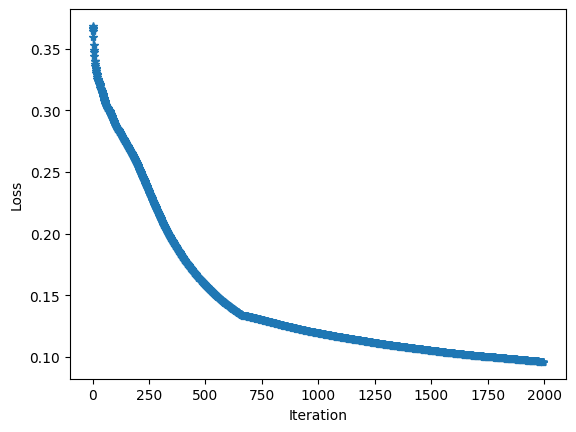

In [ ]:
loss_history = train_setup(net_attn, lr=0.001, n_batches=2000, batch_size = 64, display_freq=100, device = 'cpu')

In [ ]:
net_attn2 = Transliteration_EncoderDecoder_Attention_Type2(len(hindi_alpha2index), 256, len(eng_alpha2index))

Iteration 1999 Loss 0.09708387404680252


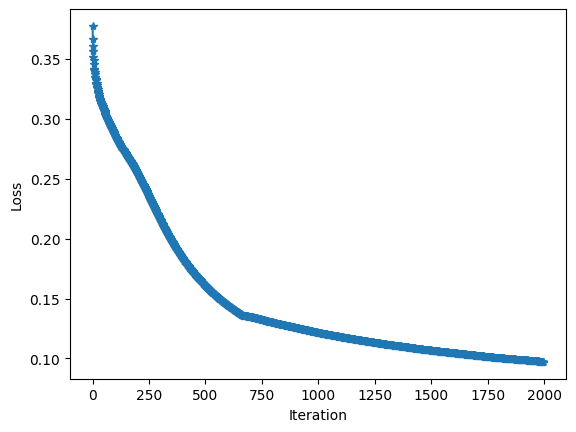

In [ ]:
loss_history = train_setup(net_attn2, lr=0.001, n_batches=2000, batch_size = 64, display_freq=100, device = 'cpu')

In [ ]:
model_load = torch.load("/content/model_attn.pt")

In [ ]:
model_load2 = torch.load("/content/model_attn2.pt")

In [ ]:
# out = infer(net_attn, "विराट", 30,device = 'cpu')
# print(len(out))
# hindi_word = ''
# for i in range(len(out)):
#     print(out[i].shape, list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])
#     a = list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))]
#     if a != "-PAD-":
#       hindi_word += a

# print("Hindi Word: ",hindi_word)

out = infer(model_load, "रोनाल्डो", 30,device = 'cpu')
print(len(out))
eng_word = ''
for i in range(len(out)):
    print(out[i].shape, list(eng_alpha2index.keys())[list(eng_alpha2index.values()).index(torch.argmax(out[i]))])
    a = list(eng_alpha2index.keys())[list(eng_alpha2index.values()).index(torch.argmax(out[i]))]
    if a != "-PAD-":
      eng_word += a

print("English Word: ",eng_word)

30
torch.Size([1, 27]) R
torch.Size([1, 27]) O
torch.Size([1, 27]) N
torch.Size([1, 27]) A
torch.Size([1, 27]) L
torch.Size([1, 27]) D
torch.Size([1, 27]) O
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
torch.Size([1, 27]) -PAD-
English Word:  RONALDO


In [ ]:
#accuracy = calc_accuracy(net) * 100
accuracy_attn = calc_accuracy(model_load) * 100
#print('Accuracy w/o attention ', accuracy)
print('Acurracy with attention', accuracy_attn)

Acurracy with attention 76.61460279916173


In [ ]:
def calc_f1_score(net, device='cpu'):
    net = net.eval().to(device)
    total_precision = 0
    total_recall = 0
    for i in range(len(test_data)):
        eng, hindi = test_data[i]
        gt = ground_truth_representation(eng, eng_alpha2index, device)
        outputs = infer(net, hindi, gt.shape[0], device)

        true_positives = 0  # Correctly predicted characters
        predicted_positives = len(outputs)  # Total characters in the predicted sequence
        actual_positives = gt.shape[0]  # Total characters in the ground truth sequence

        for index, out in enumerate(outputs):
            val, indices = out.topk(1)
            eng_pos = indices.tolist()[0]
            if eng_pos[0] == gt[index][0]:
                true_positives += 1

        precision = true_positives / predicted_positives if predicted_positives > 0 else 0
        recall = true_positives / actual_positives if actual_positives > 0 else 0
        total_precision += precision
        total_recall += recall

    avg_precision = total_precision / len(test_data)
    avg_recall = total_recall / len(test_data)
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0

    return f1_score


In [ ]:
calc_f1_score(model_load)

0.7661460279916174

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset

# Load pre-trained BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the dataset
inputs = tokenizer(training_data, return_tensors="pt", padding=True, truncation=True)
labels = torch.tensor(labels)

# Create DataLoader
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Set up optimizer and training loop
optimizer = AdamW(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for batch in dataloader:
        # Forward pass, backward pass, and optimization
        loss = model(**batch).loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()


In [ ]:
len(train_data.eng_words)

20641

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn import CrossEntropyLoss
import torch

num_epochs = 100

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased')

# Set up training data (replace this with your own data)
english_text = train_data.eng_words
hindi_transliterations = train_data.hindi_words

# Tokenize input sequences
tokenized_input = tokenizer(english_text, return_tensors='pt', padding=True, truncation=True)

# Tokenize output sequences
tokenized_output = tokenizer(hindi_transliterations, return_tensors='pt', padding=True, truncation=True)

# Train the model (replace this with your training loop)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = CrossEntropyLoss()

for epoch in range(num_epochs):
    outputs = model(**tokenized_input, labels=tokenized_output['input_ids'])
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Inference
input_text = "Ronaldo"
tokenized_input = tokenizer(input_text, return_tensors='pt', padding=True, truncation=True)
output_ids = model.generate(**tokenized_input)
output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

print(f"Input: {input_text}, Transliteration: {output_text}")
